In [1]:
import numpy as np
import pandas as pd
import os

In [7]:


df_name = pd.read_csv(
    "identity_CelebA.txt",
    sep=r"\s+",
    names=["image_id", "label"]
)

df_name.head()


,image_id,label
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [9]:
df_mask = pd.read_csv('list_attr_celeba.csv')

In [10]:
df_mask.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [15]:
num_labels = df_name["label"].nunique()
print("Количество классов (label):", num_labels)


Количество классов (label): 10177


In [17]:
label_counts = df_name["label"].value_counts()
label_counts.head(10)


label
3227    35
2820    35
3782    35
3745    34
3699    34
9152    32
8968    32
9256    32
4887    31
6568    31
Name: count, dtype: int64

In [19]:
print("Минимум фото на класс:", label_counts.min())
print("Максимум фото на класс:", label_counts.max())
print("Среднее:", label_counts.mean())
print("Медиана:", label_counts.median())


Минимум фото на класс: 1
Максимум фото на класс: 35
Среднее: 19.907536602142084
Медиана: 21.0


In [21]:
label_counts.value_counts().sort_index()


count
1       44
2      324
3      245
4      221
5      221
6      207
7      183
8      176
9      187
10     202
11     199
12     165
13     176
14     210
15     172
16     219
17     173
18     217
19     288
20    1044
21     565
22     419
23     369
24     290
25     361
26     106
27     125
28     216
29     493
30    2343
31       9
32       3
34       2
35       3
Name: count, dtype: int64

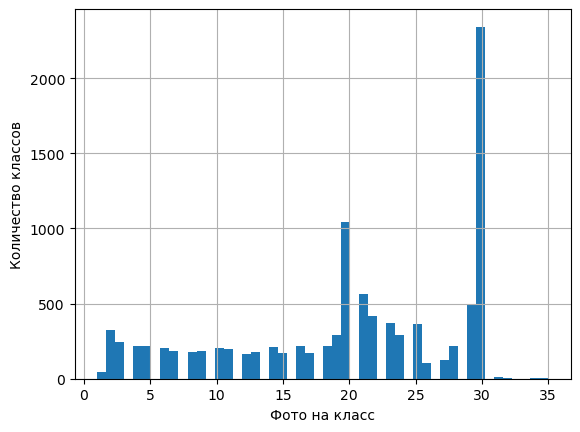

In [23]:
import matplotlib.pyplot as plt

label_counts.hist(bins=50)
plt.xlabel("Фото на класс")
plt.ylabel("Количество классов")
plt.show()


In [24]:
label_counts.describe()

count    10177.000000
mean        19.907537
std          8.925916
min          1.000000
25%         13.000000
50%         21.000000
75%         29.000000
max         35.000000
Name: count, dtype: float64


фото должны примерно соответствовать пропорциям по количеству (эти характеристики указаны в df_mask:
Male ~50/50

Young 70–85% положительных

Eyeglasses 10–20%

Smiling 40–60%

Heavy_Makeup 15–30%

Bald, Wearing_Hat по 3–8% (добрать специально)

Blurry ≤ 5% (лучше почти 0 в train)

In [27]:
label_counts[label_counts>=15].shape

(7417,)

In [29]:
attrs = [
        "Male", "Young", "Eyeglasses", "Smiling", "Heavy_Makeup",
        "Bald", "Wearing_Hat", "Blurry"
    ]


In [31]:
df_mask[attrs].mean()

Male           -0.166491
Young           0.547234
Eyeglasses     -0.869762
Smiling        -0.035839
Heavy_Makeup   -0.226156
Bald           -0.955113
Wearing_Hat    -0.903079
Blurry         -0.898203
dtype: float64

In [33]:
print(df_mask["Heavy_Makeup"].value_counts())
df_mask["Heavy_Makeup"].unique()


Heavy_Makeup
-1    124209
 1     78390
Name: count, dtype: int64


array([ 1, -1], dtype=int64)

In [35]:
def select_arcface_mainset(
    df_name: pd.DataFrame,
    df_mask: pd.DataFrame,
    label_counts: pd.Series,
    total_images: int = 12000,     # 10000..12000
    target_classes: int = 1200,    # 1000..1200
    per_class: int = 10,           # фиксируем 10
    random_state: int = 42,
    verbose: bool = True,
):
    
    rng = np.random.default_rng(random_state)

    attrs = [
        "Male", "Young", "Eyeglasses", "Smiling",
        "Heavy_Makeup", "Bald", "Wearing_Hat", "Blurry"
    ]

    # --- checks ---
    if not {"image_id", "label"}.issubset(df_name.columns):
        raise ValueError("df_name must have columns: image_id, label")

    if not {"image_id", *attrs}.issubset(df_mask.columns):
        missing = {"image_id", *attrs} - set(df_mask.columns)
        raise ValueError(f"df_mask missing columns: {missing}")

    # --- strict shape: total_images must be divisible by per_class ---
    if total_images % per_class != 0:
        raise ValueError(f"total_images must be divisible by per_class={per_class}. "
                         f"Got total_images={total_images}.")

    # --- labels with enough images for per_class ---
    eligible_labels = label_counts[label_counts >= per_class].index
    df = df_name[df_name["label"].isin(eligible_labels)].copy()

    # --- merge attributes ---
    df = df.merge(df_mask[["image_id"] + attrs], on="image_id", how="inner")
    if df.empty:
        raise ValueError("Empty after merge. Check image_id matching.")

    # --- convert -1/+1 -> 0/1 ---
    for a in attrs:
        df[a] = (df[a] == 1).astype(np.int8)

    # --- decide number of classes exactly from total_images/per_class ---
    num_classes = total_images // per_class
    num_classes = min(num_classes, target_classes, df["label"].nunique())

    # after capping num_classes, recompute total_images to keep exact per_class
    total_images = num_classes * per_class

    male_max_abs = int(np.floor(0.55 * total_images))
    male_min_abs = int(np.floor(0.45 * total_images))



    # --- hard caps (ABS) computed AFTER total_images is finalized ---
    young_min_abs = int(np.floor(0.70 * total_images))
    young_max_frac = 0.85
    young_max_abs = int(np.floor(young_max_frac * total_images))

    not_young_min_abs = int(np.floor(0.15 * total_images))


    hm_min_abs = int(np.floor(0.2 * total_images))
    hm_max_frac = 0.28
    hm_max_abs = int(np.floor(hm_max_frac * total_images))
    
    blurry_max_frac = 0.03
    blurry_max_abs = int(np.floor(blurry_max_frac * total_images))


    # --- realistic ranges (mainset) ---
    # Важно: hard-лимит Blurry. Остальные — soft-цели (не min/max), чтобы не ломать отбор.
    target_frac = {
        "Male": 0.50,
        "Young": 0.78,
        "Eyeglasses": 0.09,
        "Smiling": 0.50,
        "Heavy_Makeup": 0.23,
        "Bald": 0.03,
        "Wearing_Hat": 0.05,
        "Blurry": 0.00,     # хотим ~0
    }

    # hard max for Blurry
    blurry_max_frac = 0.03  # строже 5%; можно 0.02
    blurry_max_abs = int(np.floor(blurry_max_frac * total_images))

    # weights for global steering (Young/Male сильнее, Blurry очень сильно)
    weights = {
        "Male": 6.0,        # было 3.0
        "Young": 4.0,
        "Smiling": 0.6,
        "Heavy_Makeup": 0.8,
        "Eyeglasses": 0.8,
        "Wearing_Hat": 0.7,
        "Bald": 1.5,        # усилить
        "Blurry": 12.0,
    }


    # --- choose classes with soft bonuses (female + not-young availability) ---
    class_profile = df.groupby("label")[attrs].mean()
    female_rate = 1.0 - class_profile["Male"]
    young0_rate = 1.0 - class_profile["Young"]

    # мягкая цель: не загонять в край, просто предпочесть классы с шансом добирать female/not-young
    score_cls = (
        -6.0 * (class_profile["Male"] - 0.50).abs()          # сильнее тянем к 50/50
        -4.0 * (class_profile["Young"] - target_frac["Young"]).abs()
        -2.0 * class_profile["Blurry"]
        +0.25 * young0_rate                                   # оставить шанс на not-young
        +0.10 * class_profile["Eyeglasses"]
        +0.05 * class_profile["Wearing_Hat"]
        +0.10 * class_profile["Bald"]                         # усилить редкий Bald на уровне классов
        -0.30 * class_profile["Heavy_Makeup"]                 # штрафуем классы с макияжом
    )


    noise = rng.normal(0, 0.01, size=len(score_cls))
    labels_sorted = score_cls.index.to_numpy()[np.argsort(-(score_cls.to_numpy() + noise))]
    selected_labels = labels_sorted[:num_classes]

    df_pool = df[df["label"].isin(selected_labels)].copy()

    # --- global counters ---
    global_counts = {a: 0 for a in attrs}
    selected_rows = []

    def score_candidates(cand: pd.DataFrame, remaining: int) -> np.ndarray:
        scores = np.full(len(cand), -1e9, dtype=np.float32)
    
        selected_so_far = len(selected_rows)
        young_so_far = global_counts["Young"]
        not_young_so_far = selected_so_far - young_so_far
    
        male_arr = cand["Male"].to_numpy(dtype=np.int8)
        young_arr = cand["Young"].to_numpy(dtype=np.int8)
        hm_arr = cand["Heavy_Makeup"].to_numpy(dtype=np.int8)
        blurry_arr = cand["Blurry"].to_numpy(dtype=np.int8)
    
        # ---------- HARD MAX constraints (NEVER RELAX) ----------
        ok_max = np.ones(len(cand), dtype=bool)
    
        if global_counts["Blurry"] >= blurry_max_abs:
            ok_max &= (blurry_arr == 0)
    
        if global_counts["Male"] >= male_max_abs:
            ok_max &= (male_arr == 0)
    
        if global_counts["Young"] >= young_max_abs:
            ok_max &= (young_arr == 0)
    
        if global_counts["Heavy_Makeup"] >= hm_max_abs:
            ok_max &= (hm_arr == 0)
    
        # если даже по max нет кандидатов — это уже проблема данных в cand,
        # но не ломаем max. Просто вернём “всё запрещено”.
        if not ok_max.any():
            return scores
    
        # ---------- SOFT/FLOOR constraints (RELAXABLE) ----------
        ok = ok_max.copy()
    
        # male_min: можно ослабить, если мешает
        if global_counts["Male"] < male_min_abs:
            ok_floor = ok & (male_arr == 1)
            ok = ok_floor if ok_floor.any() else ok  # relax if empty
    
        # not-young min: можно ослабить, если мешает
        if not_young_so_far < not_young_min_abs:
            ok_floor = ok & (young_arr == 0)
            ok = ok_floor if ok_floor.any() else ok  # relax if empty
    
        # ---------- SCORING only on ok ----------
        idx = np.where(ok)[0]
        sub = cand.iloc[idx]
    
        # базовый score
        scores[idx] = 0.0
    
        for a in attrs:
            cur = global_counts[a]
            vals = sub[a].to_numpy(dtype=np.int8)
            w = weights[a]
    
            if a == "Blurry":
                scores[idx] -= w * vals
                continue
    
            tgt_abs = int(round(target_frac[a] * total_images))
            delta = (tgt_abs - cur) / max(1, remaining)
    
            scores[idx] += w * vals * delta
            scores[idx] += w * (1 - vals) * max(0.0, -delta)
    
        return scores


 
    # --- per-class greedy selection of exactly per_class images ---
    for lab in selected_labels:
        pool = df_pool[df_pool["label"] == lab].copy()

        # STRONG anti-blurry: use non-blurry pool first
        pool_non_blurry = pool[pool["Blurry"] == 0].copy()
        pool_blurry = pool[pool["Blurry"] == 1].copy()

        chosen = []
        for _ in range(per_class):
            remaining = total_images - len(selected_rows)
            if remaining <= 0:
                break

            # prefer non-blurry if available
            cand = pool_non_blurry if not pool_non_blurry.empty else pool_blurry
            if cand.empty:
                break

            scores = score_candidates(cand, remaining)
            best = cand.iloc[int(np.argmax(scores))]

            chosen.append(best)
            for a in attrs:
                global_counts[a] += int(best[a])

            img_id = best["image_id"]
            pool_non_blurry = pool_non_blurry[pool_non_blurry["image_id"] != img_id]
            pool_blurry = pool_blurry[pool_blurry["image_id"] != img_id]

        # если вдруг меньше per_class (не должно быть при label_counts>=per_class и merge ok)
        if len(chosen) != per_class:
            # fallback: добить любыми оставшимися (включая blurry), но без дублей
            remaining_need = per_class - len(chosen)
            if remaining_need > 0:
                rest = pd.concat([pool_non_blurry, pool_blurry], axis=0)
                rest = rest[~rest["image_id"].isin([r["image_id"] for r in chosen])]
                if len(rest) >= remaining_need:
                    add = rest.sample(n=remaining_need, random_state=random_state)
                    for _, row in add.iterrows():
                        chosen.append(row)
                        for a in attrs:
                            global_counts[a] += int(row[a])

        selected_rows.extend(chosen)

    selected_df = pd.DataFrame(selected_rows)

    # --- final sanity checks ---
    if len(selected_df) != total_images:
        raise ValueError(f"Selected {len(selected_df)} images, expected {total_images}. "
                         "Check merges / label_counts / per_class constraints.")

    per_class_counts = selected_df.groupby("label")["image_id"].nunique()

    report = {
        "total_selected": int(len(selected_df)),
        "num_classes_selected": int(selected_df["label"].nunique()),
        "min_per_class": int(per_class_counts.min()),
        "max_per_class": int(per_class_counts.max()),
        "selected_attr_fractions": {a: float(selected_df[a].mean()) for a in attrs},
        "pool_attr_rates": {a: float(df[a].mean()) for a in attrs},
        "blurry_max_abs": int(blurry_max_abs),
    }

    if verbose:
        print(
            "Selected:",
            report["total_selected"],
            "images;",
            report["num_classes_selected"],
            "classes;",
            "min/class:",
            report["min_per_class"],
            "max/class:",
            report["max_per_class"],
        )
        print("Pool (+1) rates:", {k: round(v, 4) for k, v in report["pool_attr_rates"].items()})
        print("Selected (+1) fractions:", {k: round(v, 4) for k, v in report["selected_attr_fractions"].items()})
        print("Blurry max abs:", report["blurry_max_abs"])

    return selected_df, report


In [37]:
selected_df, report = select_arcface_mainset(
    df_name, df_mask, label_counts,
    total_images=14000,
    target_classes=700,
    per_class=20
)


Selected: 14000 images; 700 classes; min/class: 20 max/class: 20
Pool (+1) rates: {'Male': 0.3928, 'Young': 0.8007, 'Eyeglasses': 0.0575, 'Smiling': 0.4818, 'Heavy_Makeup': 0.4151, 'Bald': 0.0197, 'Wearing_Hat': 0.0446, 'Blurry': 0.0439}
Selected (+1) fractions: {'Male': 0.5152, 'Young': 0.8347, 'Eyeglasses': 0.0931, 'Smiling': 0.4817, 'Heavy_Makeup': 0.277, 'Bald': 0.0267, 'Wearing_Hat': 0.0662, 'Blurry': 0.0046}
Blurry max abs: 420


In [39]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 117150 to 157581
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      14000 non-null  object
 1   label         14000 non-null  int64 
 2   Male          14000 non-null  int8  
 3   Young         14000 non-null  int8  
 4   Eyeglasses    14000 non-null  int8  
 5   Smiling       14000 non-null  int8  
 6   Heavy_Makeup  14000 non-null  int8  
 7   Bald          14000 non-null  int8  
 8   Wearing_Hat   14000 non-null  int8  
 9   Blurry        14000 non-null  int8  
dtypes: int64(1), int8(8), object(1)
memory usage: 437.5+ KB


In [41]:
selected_df.head()

,image_id,label,Male,Young,Eyeglasses,Smiling,Heavy_Makeup,Bald,Wearing_Hat,Blurry
117150,145014.jpg,545,1,0,0,0,1,0,0,0
98039,121245.jpg,545,1,0,0,0,0,0,0,0
116486,144182.jpg,545,1,0,0,0,0,0,0,0
59104,073086.jpg,545,1,1,0,1,0,0,0,0
92018,113723.jpg,545,1,1,0,0,1,0,0,0


In [43]:
selected_df[["image_id", "label"]].to_csv(
    r"D:\МФТИ\DL\selected_arcface_mainset_1.csv",
    index=False
)


In [45]:
print(os.path.exists(r"D:\МФТИ\DL\selected_arcface_mainset_1.csv"))


True


**Вывод:** Выбраны 14000 фото, 700 классов. Должно быть отобрано по 20 фото для каждого класса. 
